In [1]:
# Dependencies


import numpy as np
import networkx as nx
from sklearn.base import BaseEstimator, ClassifierMixin
from datasets import load_dataset
from sklearn.model_selection import cross_val_score, ShuffleSplit
from graph import process_dataset, transform

import sys

sys.path.append("../")

from hdc import hdv, bind, bundle, sbundle, ItemMemory, hdvw, hdva, cosim, hdvsc

In [2]:
# encode_graphe -> graphHD (graph, vertices, dimensions)


def encode_graphe(graph, vertices, dimensions):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)

    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        Es.append(bind([v1, v2]))

    return bundle(Es)

In [3]:
# encode_graphew -> vertices with hdw and edges (graph, vertices, base)


def encode_graphew(graph, vertices, base):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))

    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        Es.append(bind([v1, v2]))

    return bundle(Es)

In [4]:
# encode_graphv -> vertices with hdv and no edges (graph, vertices, base)


def encode_graphv(graph, vertices, dimensions):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)
        Vs.append(vertices[node])

    return bundle(Vs)

In [5]:
# encode_graphvw -> vertices with hdw and no edges (graph, vertices, base)


def encode_graphvw(graph, vertices, base):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))
        Vs.append(vertices[node])

    return bundle(Vs)

In [6]:
# encode_graphvc -> vertices with hdvc and no edges (graph, vertices, vs)


def encode_graphvc(graph, vertices, vs):
    return bundle(map(lambda n: vs[round(float(n) * len(vs))], graph.nodes))

In [7]:
class GraphClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, encoder, alpha=0.45, digits=4, step=20):
        self.encoder = encoder
        self.alpha = alpha
        self.digits = digits
        self.step = step
        self.memory = ItemMemory()
        self.vertices = dict()

    def fit(self, X, y):
        classes = {label: [] for label in set(y)}
        X = transform(X, self.alpha, self.digits)

        for i in range(len(X)):
            G = self.encoder(X[i], self.vertices)
            classes[y[i]].append(G)

        for key, value in classes.items():
            for i in range(0, len(value), self.step):
                H = bundle(value[i : i + self.step])
                self.memory.add_vector(str(key), H)

        return self

    def predict(self, X):
        p, s, queries = [], [], transform(X, self.alpha, self.digits)

        for query in queries:
            query_vector = self.encoder(query, self.vertices)
            (label, _, _) = self.memory.cleanup(query_vector)

            p.append(int(label))
            # s.append(cosine_similarity(queryVector, cleanVector[1]))

        # print("%.5f" % round(np.mean(s), 5), "0:", p.count(0), "1:", p.count(1))
        return p

In [8]:
DATASET = load_dataset("graphs-datasets/MUTAG")["train"]
# DATASET = load_dataset("graphs-datasets/PROTEINS")["train"]
# DATASET = load_dataset("graphs-datasets/AIDS")["full"]
# DATASET = load_dataset("graphs-datasets/IMDB-BINARY")["train"]

In [9]:
(graphs, labels) = process_dataset(DATASET)

In [42]:
from functools import partial
import time

FOLDS, REPS = 10, 3
ALPHA, DIGITS, DIMENSIONS, STEP, N = 0.65, 4, 10000, 4, 2000
CV = FOLDS

In [43]:
vs = hdvsc(N, DIMENSIONS, side=500, iter=1)

In [44]:
encoders = [
    partial(encode_graphe, dimensions=DIMENSIONS),
    # partial(encode_graphew, base=hdv(DIMENSIONS)),
    # partial(encode_graphv, dimensions=DIMENSIONS),
    # partial(encode_graphvw, base=hdv(DIMENSIONS)),
    partial(encode_graphvc, vs=vs),
]


def main():
    for encoder in encoders:
        clf = GraphClassifier(encoder, alpha=ALPHA, digits=DIGITS, step=STEP)
        sum = 0
        start_time = time.time()
        for i in range(REPS):
            CV = ShuffleSplit()  # random_state=0
            scores = cross_val_score(
                clf, graphs, labels, n_jobs=-1, cv=CV, verbose=0, error_score="raise"
            )
            sum += scores.mean()
        end_time = time.time()
        print(
            "S => %.5f" % (sum / REPS),
            "T => %.5f" % ((end_time - start_time) / REPS),
        )


def predict():
    for encoder in encoders:
        clf = GraphClassifier(encoder, alpha=ALPHA, digits=DIGITS, step=STEP)
        clf.fit(graphs[:150], labels[:150])
        print(clf.predict(graphs[150:]))
        print(labels[150:])


main()
# predict()

S => 0.79474 T => 0.55791
S => 0.84912 T => 1.75764


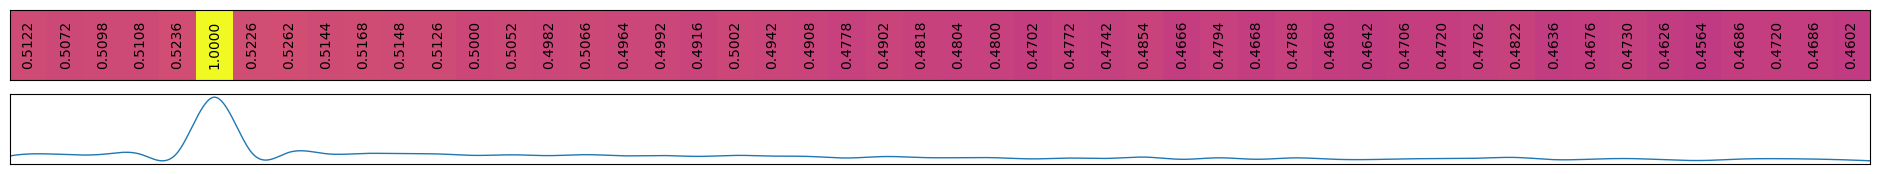

In [46]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage import gaussian_filter1d


def similarity_heatmap(xs, targets, round=2):
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)

    plt.figure(figsize=(24, 2))
    for n in range(len(targets)):
        plt.subplot(len(targets) * 2, 1, n + 2)
        sims = []

        for x in xs:
            sims.append(cosim(targets[n], x))

        xaxis = [x + 0.5 for x in range(len(xs))]
        X_Y_Spline = make_interp_spline(xaxis, sims)
        plt.xticks([]), plt.yticks([])
        plt.xlim(xmin=0, xmax=len(xs))
        X_ = np.linspace(0, len(xs), len(xs) * 16 * 2)
        Y_ = X_Y_Spline(X_)
        plt.plot(X_, Y_, linewidth=1)

        plt.subplot(len(targets) * 2, 1, n + 1)
        plt.yticks([]), plt.xticks([])
        plt.pcolormesh([sims] * 1, cmap="plasma", norm=norm)
        if round >= 0:
            for i in range(len(xs)):
                plt.text(
                    i + 0.5,
                    0 + 0.5,
                    f"%.{round}f" % sims[i],
                    ha="center",
                    va="center",
                    rotation="vertical",
                )
    plt.show()


similarity_heatmap(vs[:50], [vs[5]], round=4)